In [1]:
import tensorflow as tf
print("TF:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

TF: 2.17.1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_parquet('/Users/minkhant/Documents/Projects/NLP_Final/data/preprocessed/full_dataset.parquet')

In [4]:
df.columns

Index(['text', 'label', 'target', 'text_cleaned'], dtype='object')

In [5]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [6]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [7]:
def transform_text(text):
    tokens = word_tokenize(text)
    text = [word for word in tokens if word.isalnum() and word not in stop_words]
    text = [stemmer.stem(word) for word in text]
    text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(text)

In [8]:
df['text_transformed'] = df['text_cleaned'].apply(transform_text)

In [9]:
data = df[['text_transformed', 'target']]
train, val, test = np.split(data.sample(frac=1, random_state=42),
                            [int(0.8*len(data)), int(0.9*len(data))])
train.shape, val.shape, test.shape

/Users/minkhant/Documents/Projects/NLP_Final/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


((9827, 2), (1228, 2), (1229, 2))

In [10]:
train.head()

,text_transformed,target
450,room number wan na make sure knock right door,0
9197,massiv discount number hey guy time stock amaz...,1
2864,hi wonder anyon help locat dataset tnc fdi fou...,0
4978,dear friend sorri late inform today birthday l...,0
518,creat automobil websit well fansit car review ...,0


In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    data= dataframe.copy()
    labels = data.pop('target')
    data = data['text_transformed']
    ds = tf.data.Dataset.from_tensor_slices((data, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [13]:
list(train_data)[0]

2025-10-17 14:55:23.009877: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b'look firm like healthgrad trilliant folk realli want know got hold commerci claim dataset know buy claim ridicul expens outsid medicar medicaid startup get data',
        b'hi want visual research discus g20 twitter event perceiv twitter user data g20 number let know',
        b'project specif genr may classic game music etc import thing mood url link similar applic intend see mood column say fantasi chill dark happi etc goal gener sound relat game scene dungeon exampl gener like dark gloomi melodi jungl town happi uplift kind melodi need dataset categor mood genr matter mood tri achiev actual would awesom help',
        b'hi everyon want attempt creat sentiment analysi templat compani tool vayu url know find right data use want look sentiment novel complet noob mean import epub haha sorri stupid thank',
        b'hey social mate tire feed fill bore post friend famili want spice thing excit content well luck social network got co

In [14]:
max_tokens = 5000
encoder = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
encoder.adapt(train_data.map(lambda text, label: text))

2025-10-17 14:55:23.351821: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'number', 'get', 'data', 'like', 'look', 'dataset',
       'got', 'amaz', 'make', 'time', 'social', 'new', 'want', 'u',
       'follow', 'hashtag', 'free', 'offer'], dtype='<U17')

In [16]:
encoder

<TextVectorization name=text_vectorization, built=False>

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",          # or "val_accuracy" / "val_auc"
    patience=3,                  # epochs to wait for improvement
    restore_best_weights=True,   # roll back to the best weights
    verbose=1
)

# 2) Save only the best model checkpoint (by val_loss)
ckpt_cnn = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/cnn_best.h5",  # use .h5 (single file) or a folder for SavedModel
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,     # set True if you only want weights
    mode="min",
    verbose=1
)
callbacks_cnn = [early_stop, ckpt_cnn]

In [18]:
model_cnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True,
    ),
    tf.keras.layers.Conv1D(filters=128, kernel_size = 3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [20]:
history_cnn = model_cnn.fit(train_data, epochs=10, validation_data=valid_data, callbacks = callbacks_cnn)

Epoch 1/10


/Users/minkhant/Documents/Projects/NLP_Final/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


298/308 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8272 - loss: 0.4135
Epoch 1: val_loss improved from None to 0.05908, saving model to checkpoints/cnn_best.h5


308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9251 - loss: 0.2106 - val_accuracy: 0.9780 - val_loss: 0.0591
Epoch 2/10
294/308 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9894 - loss: 0.0307
Epoch 2: val_loss improved from 0.05908 to 0.05564, saving model to checkpoints/cnn_best.h5


308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9895 - loss: 0.0327 - val_accuracy: 0.9870 - val_loss: 0.0556
Epoch 3/10
306/308 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0119
Epoch 3: val_loss did not improve from 0.05564
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9973 - loss: 0.0108 - val_accuracy: 0.9878 - val_loss: 0.0608
Epoch 4/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0050
Epoch 4: val_loss did not improve from 0.05564
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 0.9862 - val_loss: 0.0724
Epoch 5/10
296/308 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0029
Epoch 5: val_loss did not improve from 0.05564
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.9886 - val_loss: 0.0700
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [21]:
model_cnn.evaluate(test_data)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0366


[0.036618974059820175, 0.9869812726974487]

In [22]:
import matplotlib.pyplot as plt

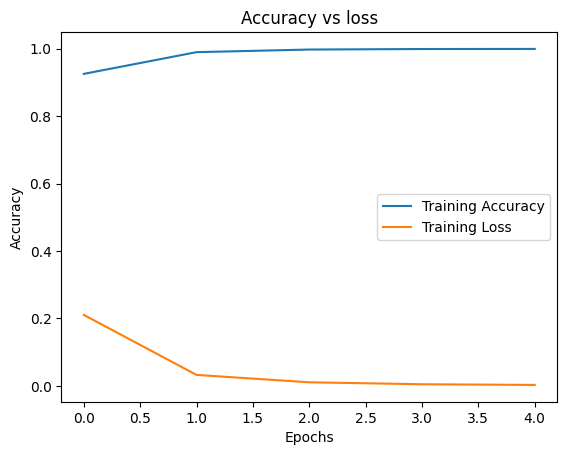

In [23]:
plt.plot(history_cnn.history['accuracy'], label = "Training Accuracy")
plt.plot(history_cnn.history['loss'], label = "Training Loss")
plt.title("Accuracy vs loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/Users/minkhant/Documents/Projects/NLP_Final/image/Accuracy vs Loss of CNN.png')
plt.show()

In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",          # or "val_accuracy" / "val_auc"
    patience=3,                  # epochs to wait for improvement
    restore_best_weights=True,   # roll back to the best weights
    verbose=1
)

# 2) Save only the best model checkpoint (by val_loss)
ckpt_lstm = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/lstm_best.h5",  # use .h5 (single file) or a folder for SavedModel
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,     # set True if you only want weights
    mode="min",
    verbose=1
)
callbacks_lstm = [early_stop, ckpt_lstm]

In [25]:
model_lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True,
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
model_lstm.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [27]:
history_lstm = model_lstm.fit(train_data, epochs=10, validation_data=valid_data, callbacks=callbacks_lstm)

Epoch 1/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8100 - loss: 0.3638
Epoch 1: val_loss improved from None to 0.05826, saving model to checkpoints/lstm_best.h5


308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9241 - loss: 0.1899 - val_accuracy: 0.9870 - val_loss: 0.0583
Epoch 2/10
305/308 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9911 - loss: 0.0380
Epoch 2: val_loss improved from 0.05826 to 0.05535, saving model to checkpoints/lstm_best.h5


308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9895 - loss: 0.0398 - val_accuracy: 0.9845 - val_loss: 0.0554
Epoch 3/10
306/308 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9933 - loss: 0.0300
Epoch 3: val_loss did not improve from 0.05535
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9946 - loss: 0.0222 - val_accuracy: 0.9845 - val_loss: 0.0590
Epoch 4/10
307/308 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9979 - loss: 0.0081
Epoch 4: val_loss did not improve from 0.05535
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9979 - loss: 0.0082 - val_accuracy: 0.9845 - val_loss: 0.0647
Epoch 5/10
305/308 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9976 - loss: 0.0092
Epoch 5: val_loss did not improve from 0.05535
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9979 - loss: 0.0083 - val_accuracy: 0.9853 - val_loss: 0.0689
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [28]:
model_lstm.evaluate(test_data)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9862 - loss: 0.0524


[0.05239854380488396, 0.9861676096916199]

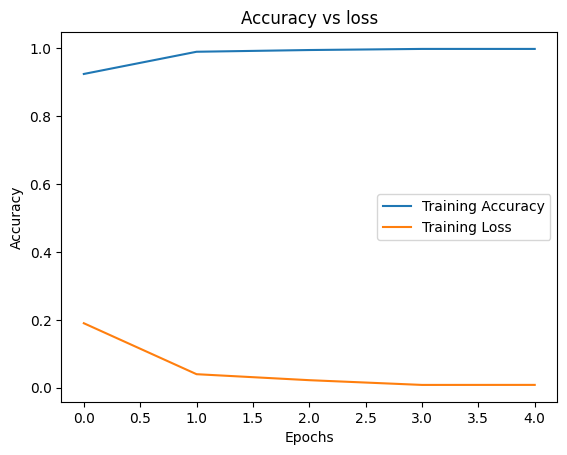

In [29]:
plt.plot(history_lstm.history['accuracy'], label = "Training Accuracy")
plt.plot(history_lstm.history['loss'], label = "Training Loss")
plt.title("Accuracy vs loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/Users/minkhant/Documents/Projects/NLP_Final/image/Accuracy vs Loss of LSTM.png')
plt.show()

In [30]:
sample = pd.read_csv("/Users/minkhant/Documents/Projects/NLP_Final/data/raw/sample_spam_ham.csv")
test = sample['text'].tolist()
texts_tensor = tf.constant(test)

probs = model_cnn.predict(texts_tensor, verbose=0).ravel()
preds = (probs >= 0.5).astype(int)

for t, p, y in zip(test, probs, preds):
    print(f"{p:.3f}", "spam" if y else "ham", "::", t[:70])

0.003 ham :: Hey, are we still meeting for lunch today?
0.007 ham :: I'll call you after the meeting finishes.
0.012 ham :: Can you send me the report by tonight?
0.003 ham :: Let's catch up this weekend at the park.
0.008 ham :: Don't forget to bring your notebook tomorrow.
0.995 spam :: Congratulations! You've won a free iPhone. Click here.
0.183 ham :: Get cheap loans approved instantly. Apply now!
0.999 spam :: Exclusive deal just for you. Claim your prize today.
0.981 spam :: You have been selected for a cash reward. Visit link.
0.417 ham :: URGENT! Verify your account to avoid suspension.


/Users/minkhant/Documents/Projects/NLP_Final/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [31]:
sample = pd.read_csv("/Users/minkhant/Documents/Projects/NLP_Final/data/raw/sample_spam_ham.csv")
test = sample['text'].tolist()
texts_tensor = tf.constant(test)

probs = model_lstm.predict(texts_tensor, verbose=0).ravel()
preds = (probs >= 0.5).astype(int)

for t, p, y in zip(test, probs, preds):
    print(f"{p:.3f}", "spam" if y else "ham", "::", t[:70])

0.015 ham :: Hey, are we still meeting for lunch today?
0.072 ham :: I'll call you after the meeting finishes.
0.125 ham :: Can you send me the report by tonight?
0.061 ham :: Let's catch up this weekend at the park.
0.013 ham :: Don't forget to bring your notebook tomorrow.
0.982 spam :: Congratulations! You've won a free iPhone. Click here.
0.706 spam :: Get cheap loans approved instantly. Apply now!
0.993 spam :: Exclusive deal just for you. Claim your prize today.
0.952 spam :: You have been selected for a cash reward. Visit link.
0.815 spam :: URGENT! Verify your account to avoid suspension.


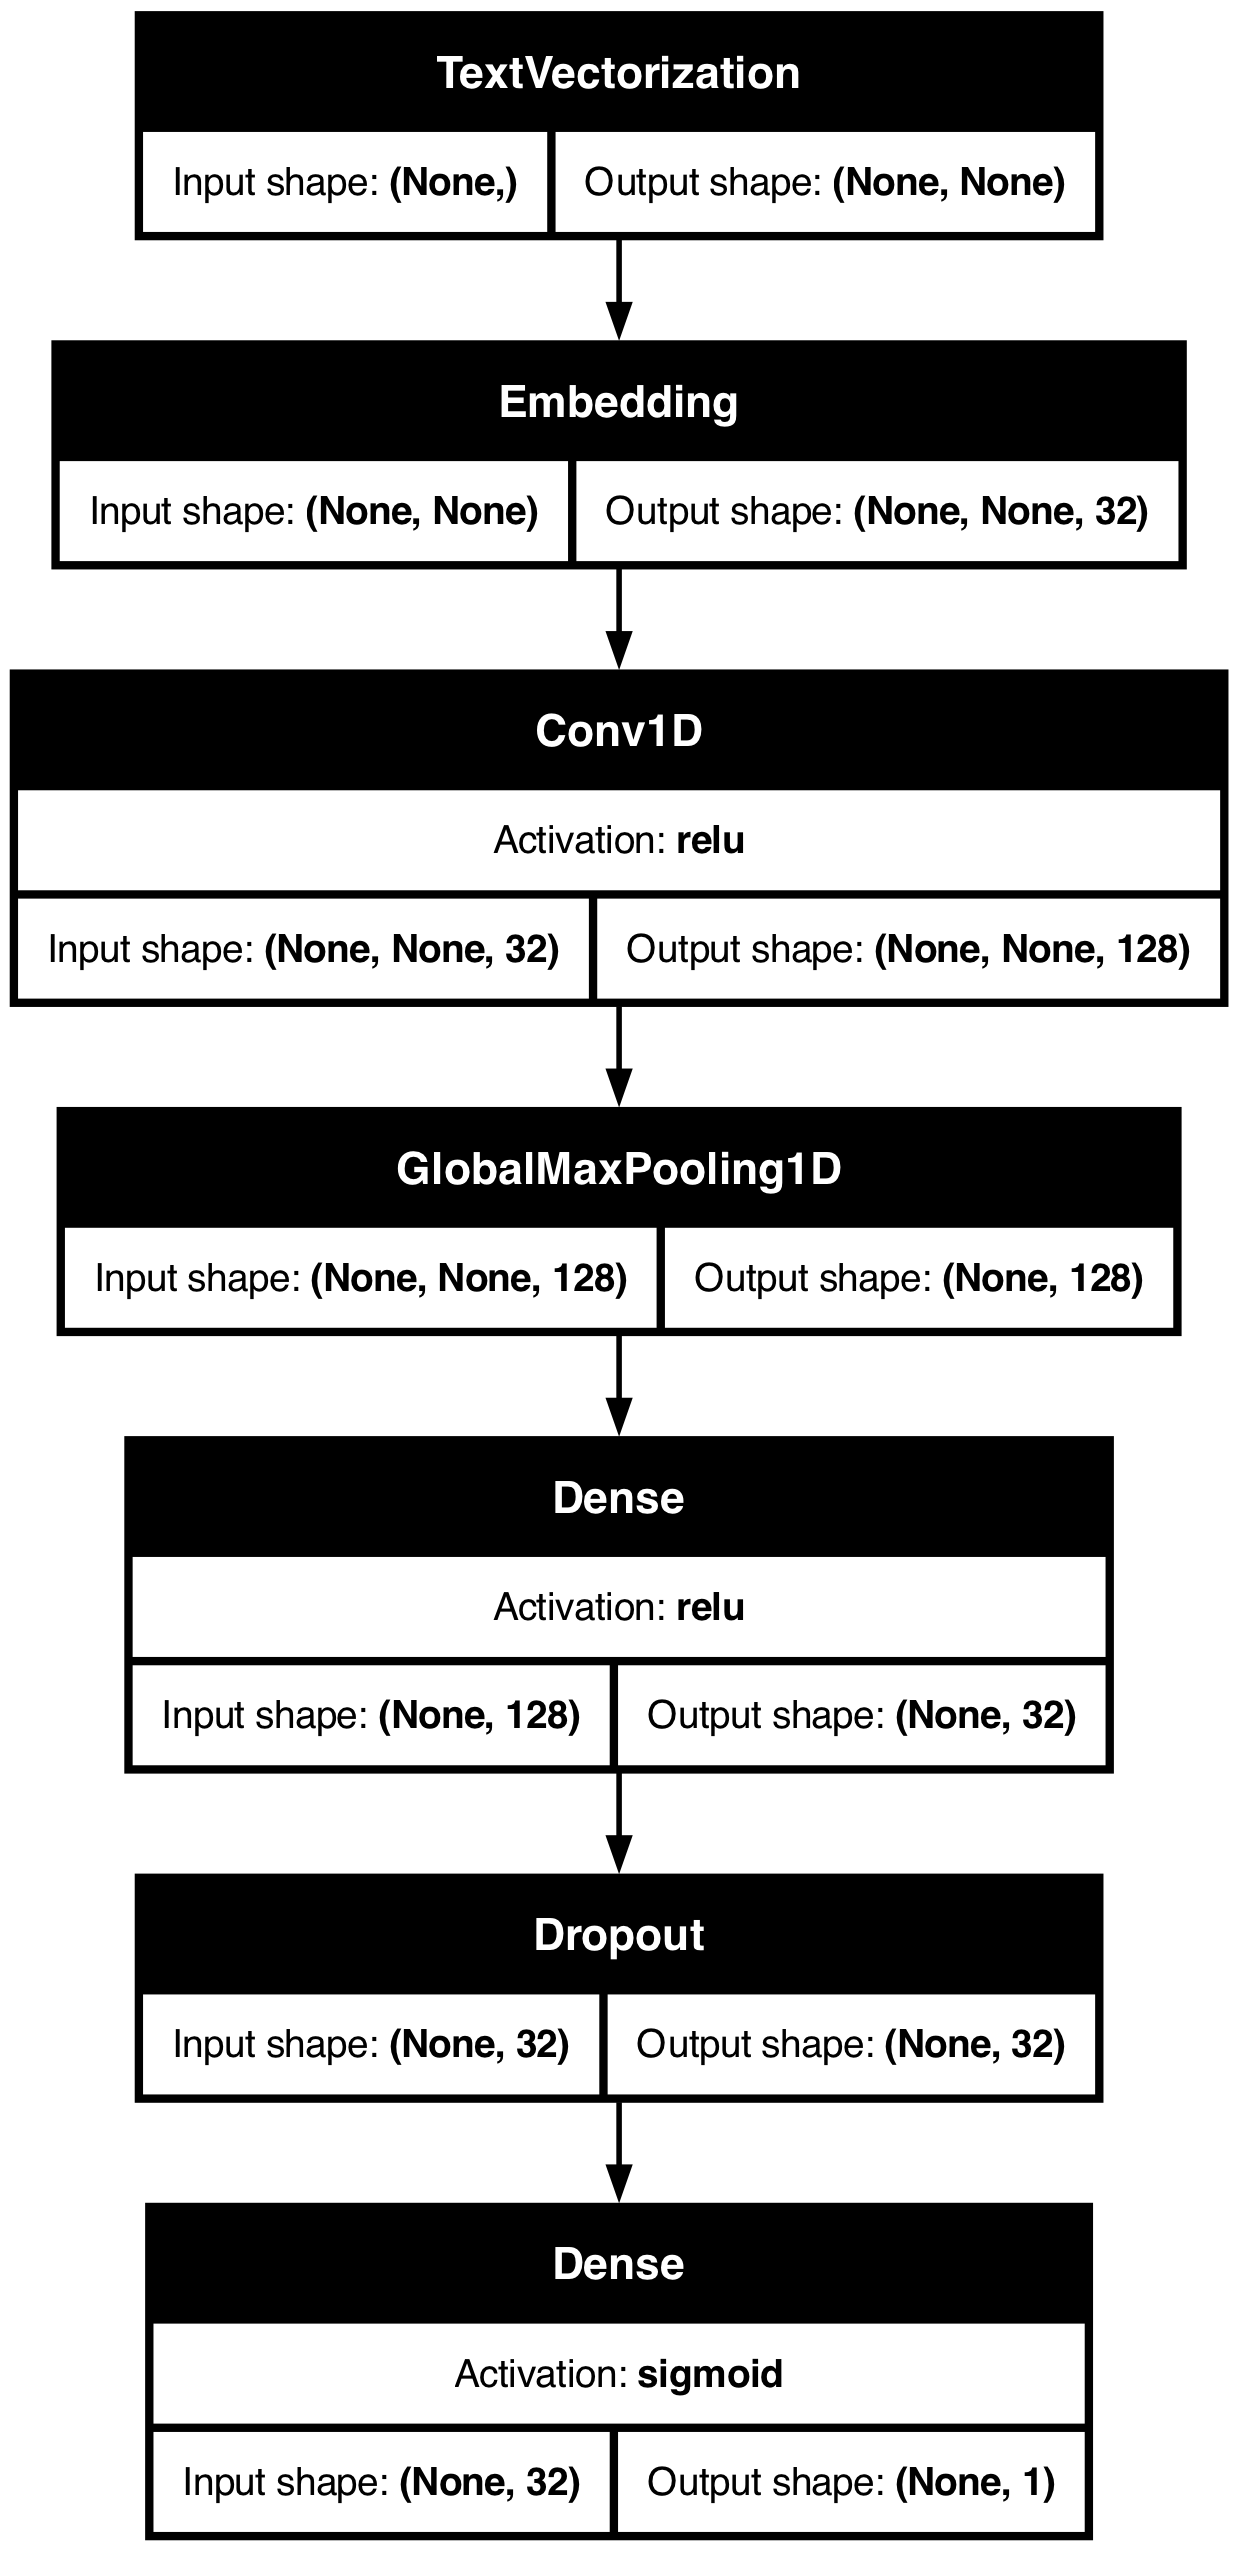

In [32]:
tf.keras.utils.plot_model(
    model_cnn,
    to_file="/Users/minkhant/Documents/Projects/NLP_Final/image/model_cnn.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=False,
)

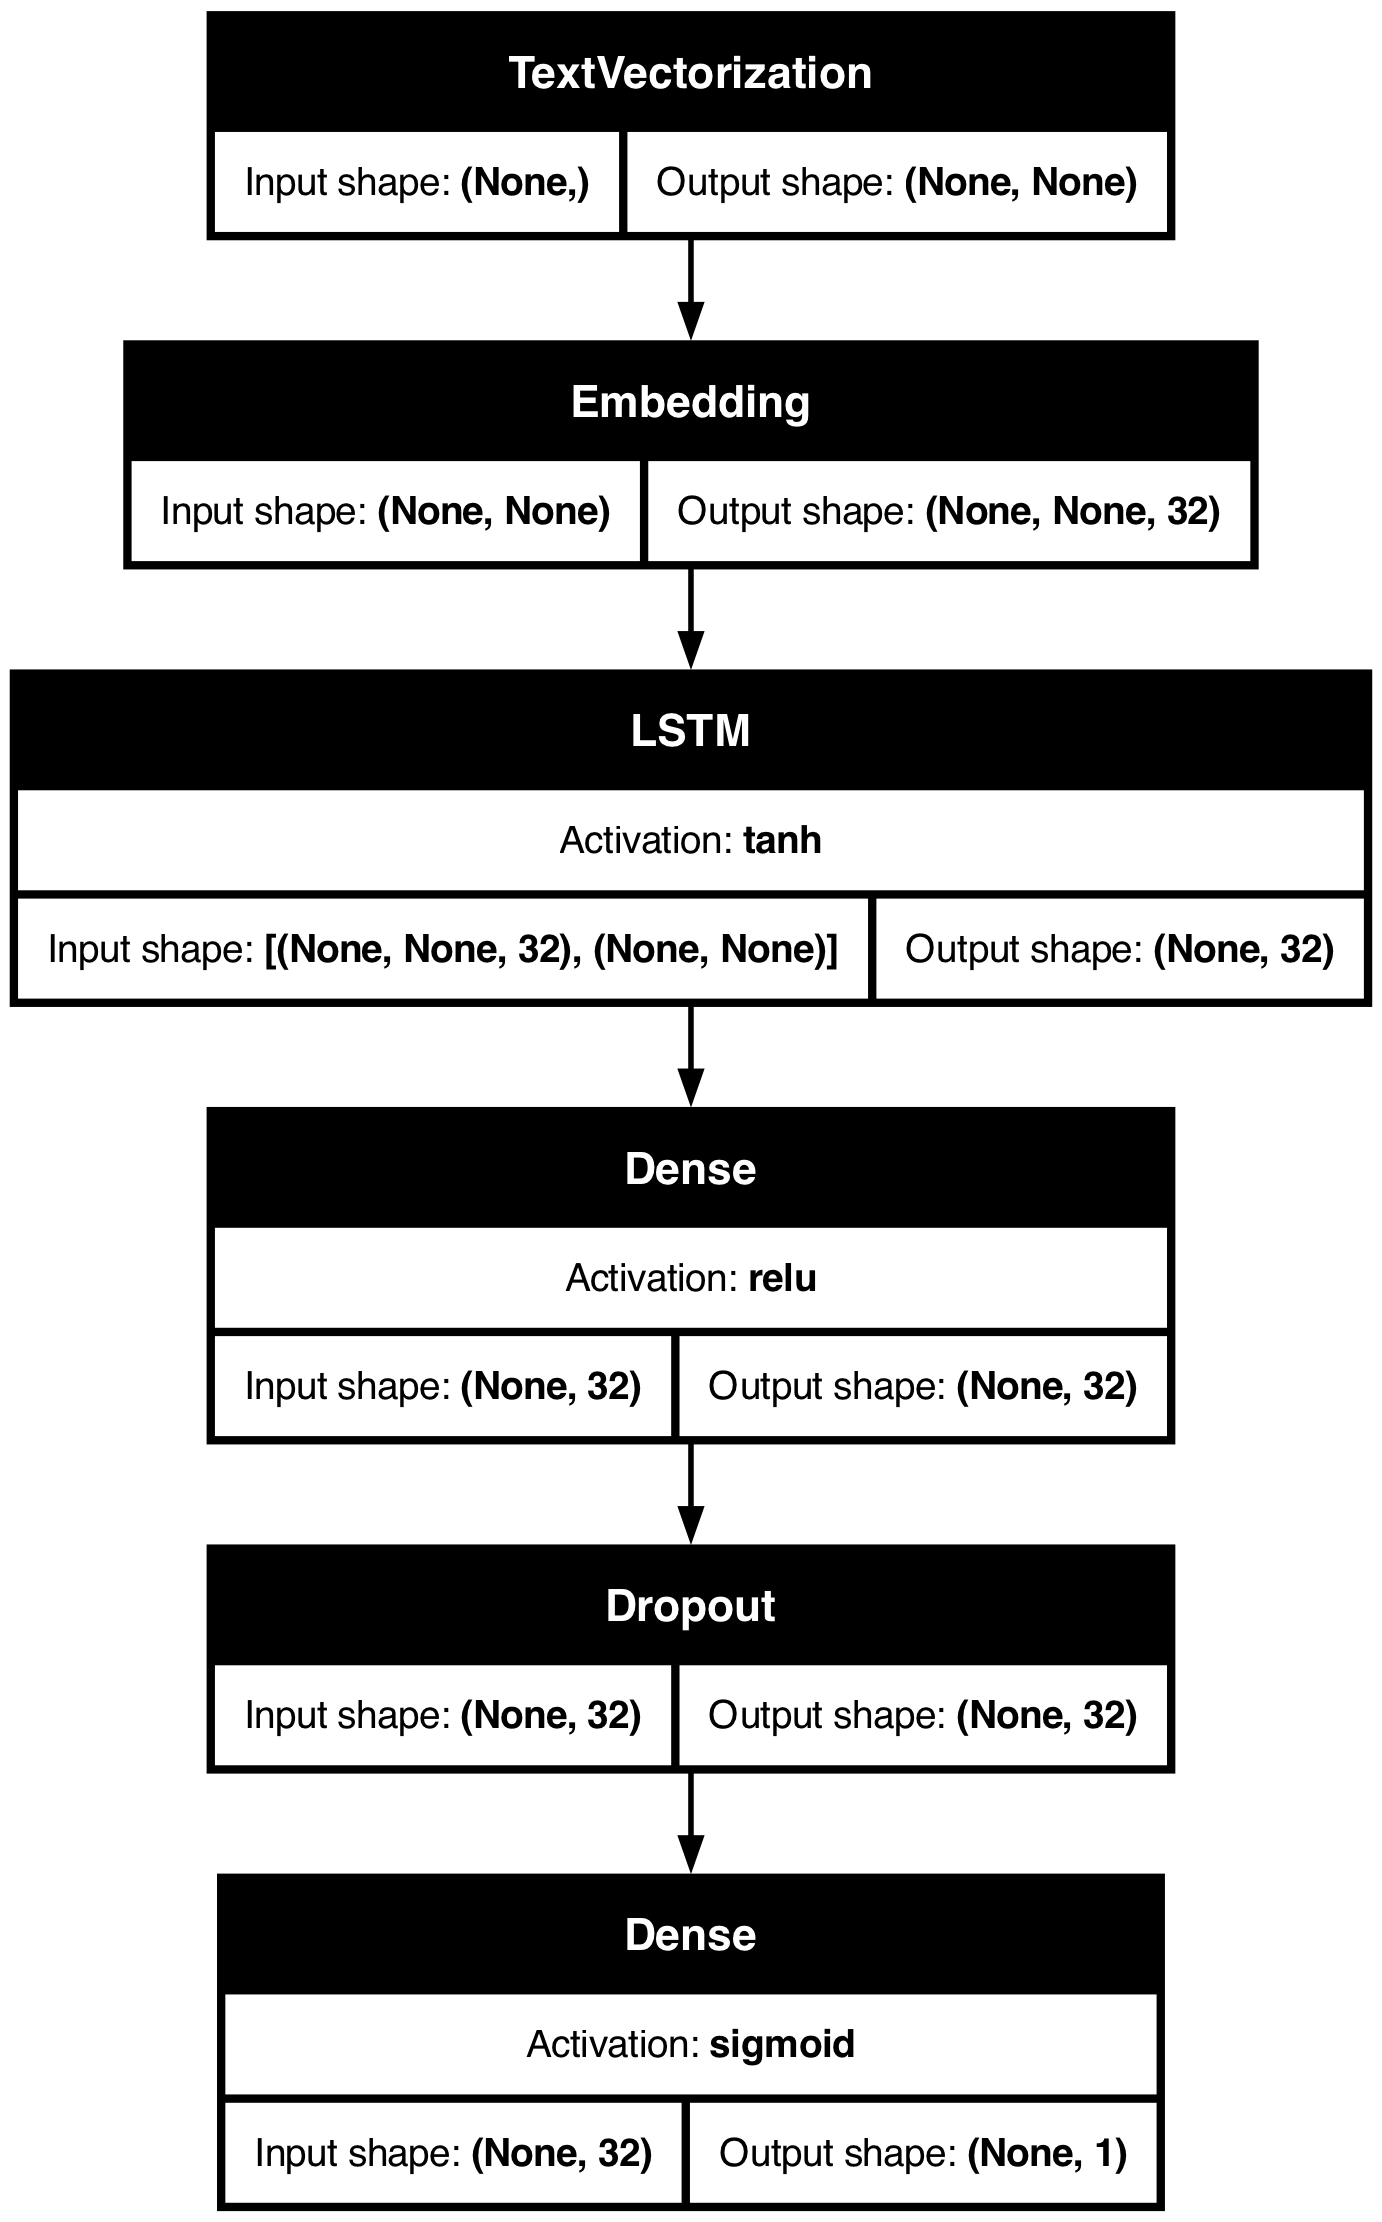

In [33]:
tf.keras.utils.plot_model(
    model_lstm,
    to_file="/Users/minkhant/Documents/Projects/NLP_Final/image/model_lstm.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=False,
)